In [1]:
%reload_ext autoreload
%autoreload 2

from qwanta.Qubit import ProbablyQuantumCircuit
from sympy import simplify, factor

from qwanta import Xperiment
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sympy import symbols

### Analytic fidelity for Entanglement swapping

First Bell pair before entanglement swapping is,

In [2]:
num_qubits = 2
qc = ProbablyQuantumCircuit(num_qubits)

for i in range(num_qubits):
    qc.dep_error(i)

s = qc.DFE(Stabilizers=['XX', 'YY', 'ZZ'], IndexStabilizer=[0, 1], Conditions=None, measure_error_var=0)
s

Variations: 64it [00:00, 360.51it/s]:00<?, ?it/s]
Variations: 64it [00:00, 1336.88it/s]00<00:00,  5.54it/s]
Variations: 64it [00:00, 972.31it/s]
Stabilizer: 100%|██████████| 3/3 [00:00<00:00,  9.89it/s]


0.0833333333333334*p_dep**2 - 0.5*p_dep*(1 - p_dep) + 0.75*(1 - p_dep)**2 + 0.25

0.266133333333333

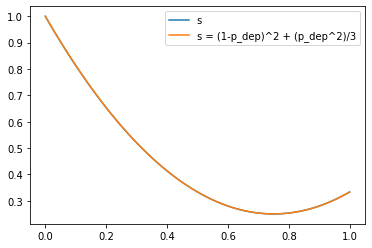

In [8]:
# Plot s as a function of the error rate
x = np.linspace(0, 1, 100)
y = [s.subs('p_dep', i) for i in x]
plt.plot(x, y, label='s')
plt.plot(x, (1-x)**2 + (x**2)/3, label='s = (1-p_dep)^2 + (p_dep^2)/3')
plt.legend()


## Compare the result with the experimental result

From https://www.nature.com/articles/s41534-019-0186-3 we can see that the experimental fidelity is 0.86. Which corresponding to p_dep approxiamtely 0.0736 

### Analytic fidelity for 0G

In [28]:
num_qubits = 4
qc = ProbablyQuantumCircuit(num_qubits)

for i in range(num_qubits):
    qc.dep_error(i)

qc.tqg('cx', 1, 2, var=0)
qc.sqg('h', 1, var=0)

qc.measure(1, 'Z', var=0)
qc.c_if('z',1 , 3, var=0)

qc.measure(2, 'Z', var=0)
qc.c_if('x', 2, 3, var=0)

s = qc.DFE(Stabilizers=['XX', 'YY', 'ZZ'], IndexStabilizer=[0, 3], Conditions=None, measure_error_var=0)

Variations: 4096it [00:04, 981.34it/s] <?, ?it/s]
Variations: 4096it [00:03, 1040.79it/s]<00:08,  4.18s/it]
Variations: 4096it [00:04, 971.60it/s]8<00:04,  4.04s/it]
Stabilizer: 100%|██████████| 3/3 [00:12<00:00,  4.11s/it]


In [29]:
def analytic_fidelity(x):
    return s.subs('p_dep', x)
s

0.0092592592592593*p_dep**4 - 0.11111111111111*p_dep**3*(1 - p_dep) + 0.499999999999998*p_dep**2*(1 - p_dep)**2 - 1.0*p_dep*(1 - p_dep)**3 + 0.75*(1 - p_dep)**4 + 0.25

In [30]:
simplify(s)

2.37037037037037*p_dep**4 - 7.11111111111111*p_dep**3 + 8.0*p_dep**2 - 4.0*p_dep + 1.0

In [34]:
def simulate_model(parameter):
    message_log = 'exp_id4_0G_Testing'
    distance = 100

    index = parameter['index']
    loss = parameter['loss rate'] # dB/km
    depo_prob = parameter['depolarizing rate']
    gate_error = parameter['gate error rate']
    measurement_error = parameter['measurement error']
    memory_time = parameter['memory error']
    repeat_th = parameter['trajectory']

    num_hops = parameter['number of hops']
    num_nodes = num_hops + 1

    node_info = {f'Node {i}': {'coordinate': (int(dis), 0, 0)} for i, dis in enumerate(np.linspace(0, distance, num_nodes))}
    edge_info = {
        (f'Node {i}', f'Node {i+1}'): {
        'connection-type': 'Space',
        'depolarlizing error': [1 - depo_prob, depo_prob/3, depo_prob/3, depo_prob/3],
        'loss': loss,
        'light speed': 300000,
        'Pulse rate': 0.00001,
        f'Node {i}':{
            'gate error': gate_error,
            'measurement error': measurement_error,
            'memory function': memory_time
        },
        f'Node {i+1}':{
            'gate error': gate_error,
            'measurement error': measurement_error,
            'memory function': memory_time
        },
        }
    for i in range(num_hops)}

    exps = Xperiment(
        timelines_path = f'exper_id6_selectedStats_{num_hops}hops.xlsx',
        nodes_info_exp = node_info,
        edges_info_exp = edge_info,
        gate_error = gate_error,
        measurement_error = measurement_error,
        memory_time = memory_time,
        experiment = f'{message_log}_p{index}_r{repeat_th}',
        strategies_list=['0G']
    )

    result = exps.execute(save_result=True)
    return result

In [35]:
parameters = []

p_dep_range = np.linspace(0, 1, 11)
for trajectory in range(10):
    for index, p_dep in enumerate(p_dep_range):
        parameters.append({
            'index': index,
            'loss rate': 0, 
            'depolarizing rate': p_dep, 
            'gate error rate': 0, 
            'memory error': np.Infinity,
            'measurement error': 0,
            'number of hops': 2,
            'trajectory': trajectory
        })

In [36]:
fidelities_0G = []

for parameter in parameters:
    result = simulate_model(parameter)
    fidelity = result['0G']['fidelity']
    fidelities_0G.append({
        'depolarizing rate': parameter['depolarizing rate'],
        'fidelity': fidelity,
        'trajectory': parameter['trajectory']
    })

In [39]:
data_simulated = pd.DataFrame(fidelities_0G)
#data['analytic fidelity'] = data.apply(lambda row: float(analytic_fidelity(row['depolarizing rate'])), axis=1)
data_simulated['result'] = data_simulated.apply(lambda row: 'Simulated', axis=1)
data_analytic = data_simulated.copy(deep=True)
data_analytic['fidelity'] = data_analytic.apply(lambda row: float(analytic_fidelity(row['depolarizing rate'])), axis=1)
data_analytic['result'] = data_analytic.apply(lambda row: 'Analytic', axis=1)
data = pd.concat([data_analytic, data_simulated], ignore_index=True)
data.to_csv('Fidelity_0G_model.csv')
data

,depolarizing rate,fidelity,trajectory,result
0,0.0,1.000000,0,Analytic
1,0.1,0.673126,0,Analytic
2,0.2,0.466904,0,Analytic
3,0.3,0.347200,0,Analytic
4,0.4,0.285570,0,Analytic
...,...,...,...,...
215,0.6,0.250667,9,Simulated
216,0.7,0.240500,9,Simulated
217,0.8,0.236000,9,Simulated
218,0.9,0.242667,9,Simulated


In [40]:
data = pd.read_csv('Fidelity_0G_model.csv')

<AxesSubplot:xlabel='depolarizing rate', ylabel='fidelity'>

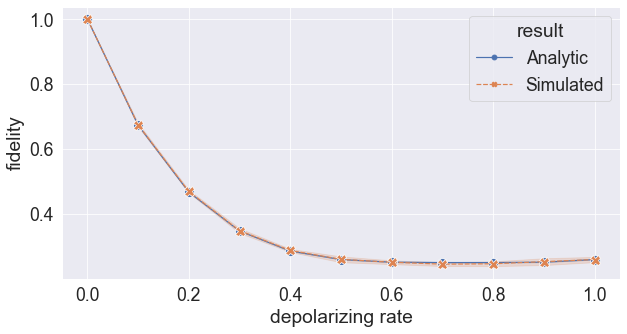

In [41]:
sns.set_context("paper", font_scale=2)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=data, x='depolarizing rate', y='fidelity', ci='sd',
             style='result', hue='result', ax=axes, markers=True, markersize=10)

### Simulate 1G

In [42]:
def simulate_1G_model(parameter):
    message_log = 'exp_id4_1G_Testing_extended'
    distance = 100

    index = parameter['index']
    loss = parameter['loss rate'] # dB/km
    depo_prob = parameter['depolarizing rate']
    gate_error = parameter['gate error rate']
    measurement_error = parameter['measurement error']
    memory_time = parameter['memory error']
    repeat_th = parameter['trajectory']

    num_hops = parameter['number of hops']
    num_nodes = num_hops + 1

    node_info = {f'Node {i}': {'coordinate': (int(dis), 0, 0)} for i, dis in enumerate(np.linspace(0, distance, num_nodes))}
    edge_info = {
        (f'Node {i}', f'Node {i+1}'): {
        'connection-type': 'Space',
        'depolarlizing error': [1 - depo_prob, depo_prob/3, depo_prob/3, depo_prob/3],
        'loss': loss,
        'light speed': 300000,
        'Pulse rate': 0.00001,
        f'Node {i}':{
            'gate error': gate_error,
            'measurement error': measurement_error,
            'memory function': memory_time
        },
        f'Node {i+1}':{
            'gate error': gate_error,
            'measurement error': measurement_error,
            'memory function': memory_time
        },
        }
    for i in range(num_hops)}

    exps = Xperiment(
        timelines_path = f'exper_id6_selectedStats_{num_hops}hops.xlsx',
        nodes_info_exp = node_info,
        edges_info_exp = edge_info,
        gate_error = gate_error,
        measurement_error = measurement_error,
        memory_time = memory_time,
        experiment = f'{message_log}_p{index}_r{repeat_th}',
        strategies_list=['1G-Ss-Dp']
    )

    result = exps.execute(save_result=True)
    return result

In [43]:
parameters = []

p_dep_range = np.linspace(0, 1, 21)
for trajectory in range(10):
    for index, p_dep in enumerate(p_dep_range):
        parameters.append({
            'index': index,
            'loss rate': 0, 
            'depolarizing rate': p_dep, 
            'gate error rate': 0, 
            'memory error': np.Infinity,
            'measurement error': 0,
            'number of hops': 2,
            'trajectory': trajectory
        })

In [44]:
fidelities_1G = []

for parameter in parameters:
    result = simulate_1G_model(parameter)
    fidelity = result['1G-Ss-Dp']['fidelity']
    fidelities_1G.append({
        'depolarizing rate': parameter['depolarizing rate'],
        'fidelity': fidelity,
        'trajectory': parameter['trajectory']
    })

In [2]:
def analytic_fidelity_1G(x):

    p, F = symbols('p F')
    Ss_Dp_F = (224*p**4 - 672*p**3 + 756*p**2 - 378*p + 81)/(256*p**4 - 768*p**3 + 792*p**2 - 324*p + 81)
    F_swapped = F**2 + (1 - F)*(1 - F)/3
    Fidelity_1G = F_swapped.subs(F, Ss_Dp_F)

    return Fidelity_1G.subs(p, x)

In [46]:
data_simulated_1G = pd.DataFrame(fidelities_1G)

data_simulated_1G['result'] = data_simulated_1G.apply(lambda row: 'Simulated', axis=1)
data_analytic_1G = data_simulated_1G.copy(deep=True)
data_analytic_1G['fidelity'] = data_analytic_1G.apply(lambda row: float(analytic_fidelity_1G(row['depolarizing rate'])), axis=1)
data_analytic_1G['result'] = data_analytic_1G.apply(lambda row: 'Analytic', axis=1)
data = pd.concat([data_analytic_1G, data_simulated_1G], ignore_index=True)
data.to_csv('Fidelity_1G_model_extended.csv')
data

,depolarizing rate,fidelity,trajectory,result
0,0.00,1.000000,0,Analytic
1,0.05,0.918992,0,Analytic
2,0.10,0.810557,0,Analytic
3,0.15,0.683014,0,Analytic
4,0.20,0.552846,0,Analytic
...,...,...,...,...
415,0.80,0.249667,9,Simulated
416,0.85,0.250167,9,Simulated
417,0.90,0.243167,9,Simulated
418,0.95,0.245833,9,Simulated


<AxesSubplot:xlabel='depolarizing rate', ylabel='fidelity'>

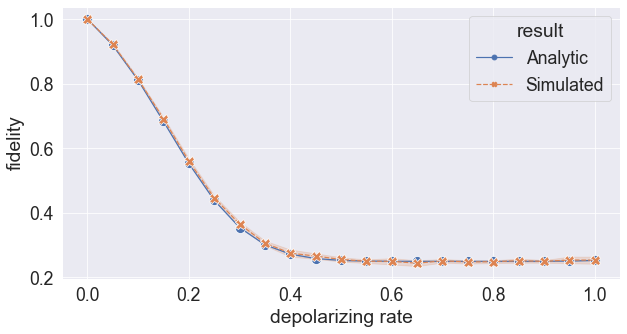

In [47]:
data = pd.read_csv('Fidelity_1G_model_extended.csv')
sns.set_context("paper", font_scale=2)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=data, x='depolarizing rate', y='fidelity', ci='sd',
             style='result', hue='result', ax=axes, markers=True, markersize=10)

In [3]:
p, F = symbols('p F')
Ss_Dp_F = (224*p**4 - 672*p**3 + 756*p**2 - 378*p + 81)/(256*p**4 - 768*p**3 + 792*p**2 - 324*p + 81)
F_swapped = F**2 + (1 - F)*(1 - F)/3
Fidelity_1G = F_swapped.subs(F, Ss_Dp_F)

In [6]:
simplify(Ss_Dp_F)

(224*p**4 - 672*p**3 + 756*p**2 - 378*p + 81)/(256*p**4 - 768*p**3 + 792*p**2 - 324*p + 81)

In [7]:
F_swapped

F**2 + (1 - F)**2/3